# Opimisation thèse Manon

### Import des librairies

In [22]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import typing as ty
from collections.abc import Callable
from mpl_toolkits.mplot3d import axes3d

#Custom type hints
Vector = npt.NDArray[np.float64] # Column vector (n,1)
VectorArray = npt.NDArray[np.float64] # Array (n,N)
ScalarArray = npt.NDArray[np.float64] # Array (1,n)
Matrix = npt.NDArray[np.float64] # Array (n,n)

## Custom plot 3D

### Code

In [23]:
def convert(function: Callable[[VectorArray],float], Xgrid: Matrix, Ygrid: Matrix) -> Matrix:
    """Permet de convertir une fonction prenant un array de points en une fonction prenant une grille (pour l'affichage 3D)."""
    points = np.vstack([Xgrid.flatten(), Ygrid.flatten()])
    Zgrid = function(points)
    return Zgrid.reshape(Xgrid.shape)

In [27]:
def comparaison3DPlot(function_to_plot: Callable[[VectorArray],ScalarArray], 
                      domain: list[Matrix], 
                      function_constrain: Callable[[VectorArray],ScalarArray]=None, 
                      points: VectorArray=None):
    """
    Affichage comparatif (3D et projeté dans le plan) d'une fonction avec affichage de la contrainte et de points si besoin.
    
    La contrainte est respectée si la fonction est positive;
    Le domain (domain) est sous la forme d'une meshgrid;
    """
    # Création de l'espace figure
    fig = plt.figure(figsize=plt.figaspect(0.45),layout='constrained')
    fig.suptitle("Etat de l'optimisation")
    
    # Plot 3D et 2D
    ax3D = fig.add_subplot(1, 2, 2, projection='3d')
    ax2D = fig.add_subplot(1, 2, 1)
    X, Y = domain
    
    # coût
    Zcout = convert(function_to_plot, X, Y)
    surfCout = ax3D.plot_surface(X, Y, Zcout, rstride=1, cstride=1, linewidth=0, antialiased=True, color="purple", alpha=0.6, label="coût")
    flatCout = ax2D.pcolormesh(X, Y, Zcout, cmap="plasma")
    
    # contrainte
    if not(function_constrain is None):
        Zcont = convert(function_constrain, X, Y)
        flatCont = ax2D.contour(X,Y,Zcont,levels=[0.])
        contour3DCont = ax3D.contourf(X,Y,Zcont,levels=[np.min(Zcont),0.,np.max(Zcont)],offset=-np.min(Zcout),alpha=0.7)
        
    # points
    if not(points is None):
        points_2D_2D = ax2D.plot(points[0,:], points[1,:], color="red", marker="x", label="points")
        points_2D_3D = ax3D.plot(points[0,:], points[1,:], np.zeros(points[0,:].shape)-np.min(Zcout), color="red", marker="x", label="points")
        points_2D_3D = ax3D.plot(points[0,:], points[1,:], function_to_plot(points), color="orange", marker="x", label="points")
        
    # Cosmétique
    ax3D.grid(True)
    ax3D.set_xlabel('x1')
    ax3D.set_ylabel('x2')
    ax3D.set_zlabel('z')
    ax3D.set_zlim([np.min(Zcout),np.max(Zcout)])
    ax3D.legend()
    ax2D.clabel(flatCont, fmt="contrainte")
    ax2D.legend()
    ax2D.grid(True)
    ax2D.set_xlabel('x1')
    ax2D.set_ylabel('x2')
    fig.colorbar(flatCout, ax=ax2D, label="coût")
    fig.colorbar(contour3DCont, ax=ax3D, label="contrainte")
    
    plt.show()

### Exemple de plot

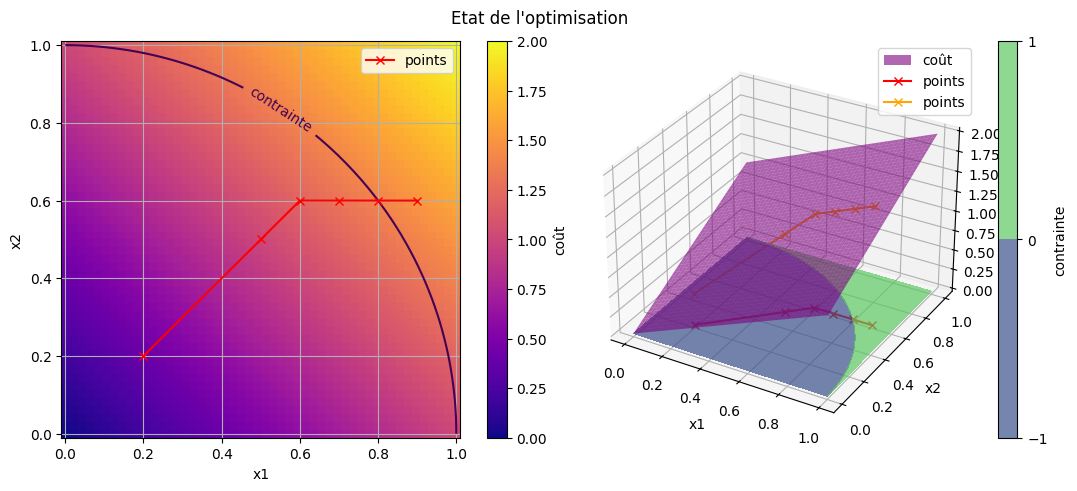

In [28]:
f_test = lambda points: points[0,:]+points[1,:]
h_test = lambda points: points[0,:]**2+points[1,:]**2-1

Xdomain = np.linspace(0,1)
X,Y = np.meshgrid(Xdomain,Xdomain)
points = np.array([[0.2, 0.5, 0.6, 0.7, 0.8, 0.9],
                   [0.2, 0.5, 0.6, 0.6, 0.6, 0.6]])
        
comparaison3DPlot(f_test,[X,Y],h_test, points)

## Présentation du problème

#### Définition mathématique du problème

On souhaite résoudre le problème suivant :
$$
    \min_{x\in K} f(x), \quad \text{with } K=\{x\in(\mathbb{R}_+^*)^n \vert h(x)\geq 0\}.
$$
Avec :
$$
    f(x)=\sum_{i=1}^n x_i, \quad h(x)=\text{Module de stabilité de la matrice }A(x).
$$

### Définitions basiques

#### Elements utiles

In [29]:
# Matrice D (points du graph)
D12=1.4
D21=0.8
D13 = 0.8
D31 = 0.2
D32 = 0.6
D23 = 0.5

D = np.array([[-D21-D31,D12,D13],
              [D21,-D12-D32,D23],
              [D31,D32,-D13-D23]])
# D42 = 0; D52 = 0; D24 = 0; D25=0;D43=0;D53=0;D34=0;D35=0

# Constantes et fonctions
n = np.shape(D)[0] 
I = np.eye(n)
geneGFonc = lambda a,K: lambda x: a-x/K

#### Matrice A(x)

In [30]:
g1= geneGFonc(0.7, 2)
g2= geneGFonc(0.5, 3)
g3= geneGFonc(0.2, 4)

def A(points: VectorArray) -> list[Matrix]:
    """Fonction A optimisée pour le calcul."""
    return [np.diag([g1(0)-p[0],g2(0)-p[1],g3(0)]) +D for p in points.T]

#### Module de stabilité (contrainte)

In [31]:
def h_old(x: Vector) -> float:
    eigv, eigp = np.linalg.eig(A(x))
    real = eigv.real
    return max(real)

def h(points: VectorArray) -> ScalarArray:
    """Fonction h optimisée pour le calcul."""
    return np.array([np.max(np.linalg.eig(matA)[0].real) for matA in A(points)])

#### Coût et affichage

In [32]:
def f(points: VectorArray) -> ScalarArray:
    """Fonction de coût f optimisée."""
    return points[0,:]+points[1,:]

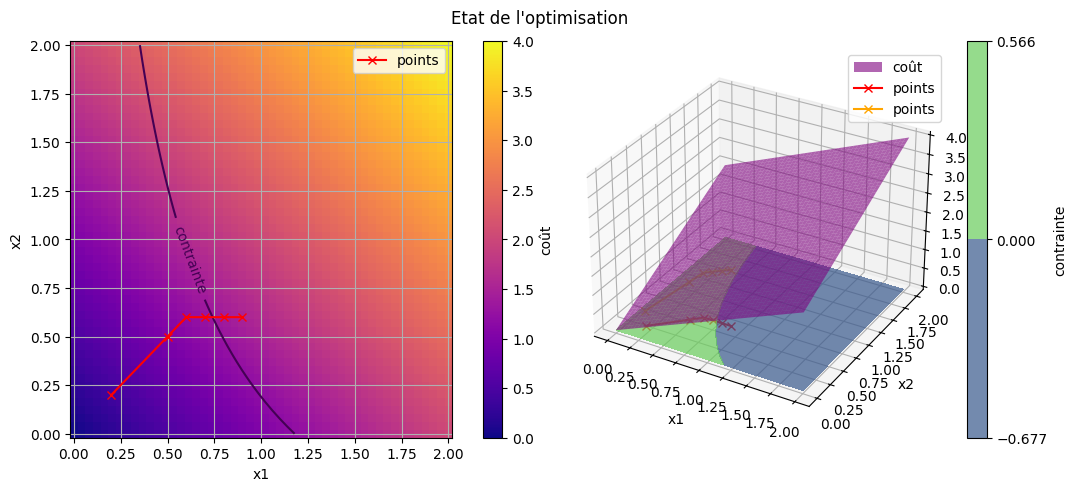

In [34]:
Xdomain = np.linspace(0,2)
X,Y = np.meshgrid(Xdomain,Xdomain)
points = np.array([[0.2, 0.5, 0.6, 0.7, 0.8, 0.9],
                   [0.2, 0.5, 0.6, 0.6, 0.6, 0.6]])
        
comparaison3DPlot(f,[X,Y],h, points)

### Pré-calculs pour l'optimisation

## Optimisation par points intérieurs

In [36]:
### Méthode

In [ ]:
### 